<a href="https://www.kaggle.com/code/agastyapatel/ls04-us-patent-phrase-matching?scriptVersionId=162758047" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
        
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-patent-phrase-to-phrase-matching/sample_submission.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/train.csv
/kaggle/input/us-patent-phrase-to-phrase-matching/test.csv


This notebook has been inspired by Jeremy Howard's nb https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners
Most practical used applications of NLP is classifiction:
* Sentiment Analysis
* Author identification
* Legal Discovery
* Organising document by topic
* Triaging inbound emails
Competition 

In [2]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE')
iskaggle

'Batch'

In [3]:
from pathlib import Path
path = Path('us-patent-phrase-to-phrase-matching')
path

PosixPath('us-patent-phrase-to-phrase-matching')

In [4]:
# Download the dataaset if the env is not kaggle
if not iskaggle and not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_file(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

## Import EDA

In [5]:
if iskaggle:
    path = Path('../input/us-patent-phrase-to-phrase-matching')
    !pip install -q datasets  # Installing hugging face datasets

In [6]:
!ls {path}

sample_submission.csv  test.csv  train.csv


In [7]:
import pandas as pd
df = pd.read_csv(path/'train.csv')

In [8]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [9]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,8d135da0b55b8c88,component composite coating,composition,H01
freq,1,152,24,2186


In [10]:
df['input'] = 'CASE1: ' + df.context + '| CASE2: ' + df.target + '| ANC1: ' + df.anchor 

In [11]:
df.input.head()

0    CASE1: A47| CASE2: abatement of pollution| ANC...
1    CASE1: A47| CASE2: act of abating| ANC1: abate...
2    CASE1: A47| CASE2: active catalyst| ANC1: abat...
3    CASE1: A47| CASE2: eliminating process| ANC1: ...
4    CASE1: A47| CASE2: forest region| ANC1: abatement
Name: input, dtype: object

## Tokenization

Transformers uses a Dataset object for storing dataset

In [12]:
from datasets import Dataset, DatasetDict

ds = Dataset.from_pandas(df)

In [13]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

We can't pass a text directly into deep learning model as it only understands the number
Preprocessing for NLP:
* Tokenization: Split each text up into token
* Numericalization: Convert each token into number

In [14]:
# Tokenization and numericalization is differently designed for all models.
# We will choose our model
model_nm = 'microsoft/deberta-v3-small'

AutoTokenizer in transformers library would automatically create the tokenizer for the appropriate model

In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:515: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [16]:
tokz

DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-small', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [17]:
tokz.tokenize('Hello, folks. I\'m Agastya, Deep Learning Enthusiast')

['▁Hello',
 ',',
 '▁folks',
 '.',
 '▁I',
 "'",
 'm',
 '▁Aga',
 'st',
 'ya',
 ',',
 '▁Deep',
 '▁Learning',
 '▁Enthusiast']

Uncommon word like my name gets splitted into smaller pieces whereas commonly used words are considered as an entire token

In [18]:
def tok_func(x): return tokz(x['input'])

In [19]:
# Tokenizing our dataset
# Map is used to tokenize texts in parallel 
tok_ds = ds.map(tok_func, batched = True)

  0%|          | 0/37 [00:00<?, ?ba/s]

In [20]:
tok_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

In [21]:
row = tok_ds[0]
row

{'id': '37d61fd2272659b1',
 'anchor': 'abatement',
 'target': 'abatement of pollution',
 'context': 'A47',
 'score': 0.5,
 'input': 'CASE1: A47| CASE2: abatement of pollution| ANC1: abatement',
 'input_ids': [1,
  36381,
  435,
  294,
  336,
  5753,
  4873,
  36381,
  445,
  294,
  47284,
  265,
  6435,
  4873,
  23702,
  435,
  294,
  47284,
  2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [22]:
tokz.vocab['▁of']

265

transformers library assumes the column name 'label'

In [23]:
tok_ds = tok_ds.rename_columns({'score': 'labels'})

## Test and Validation set

In [24]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,hybrid bearing,inorganic photoconductor drum,G02
freq,1,2,1,3


### Overfitting

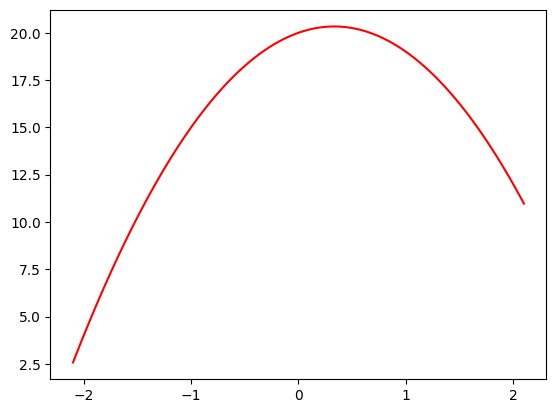

In [25]:
def f(x): return -3*x**2 + 2*x + 20
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min= -2.1, max=2.1, color='r'):
    x = np.linspace(min, max, 100)[:, None]
    plt.plot(x, f(x), color)

plot_function(f)

In [26]:
# Simulating real world data points with noise
from numpy.random import normal, seed, uniform
np.random.seed(42)

def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x+(1+noise(x, mult)) + noise(x, add)

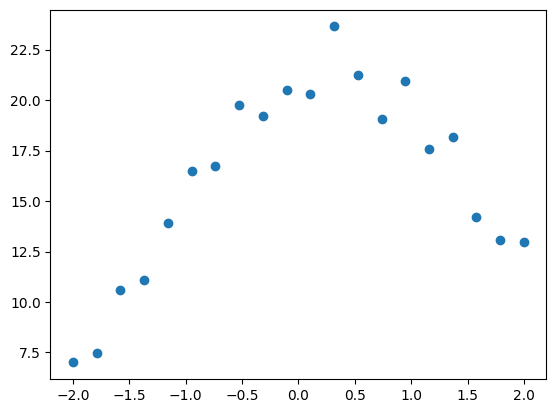

In [27]:
x= np.linspace(-2, 2, num = 20)[:, None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y)

In [28]:
# Comparing the functions capacity for fitting prediction
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x, y)
    plot_function(model.predict)

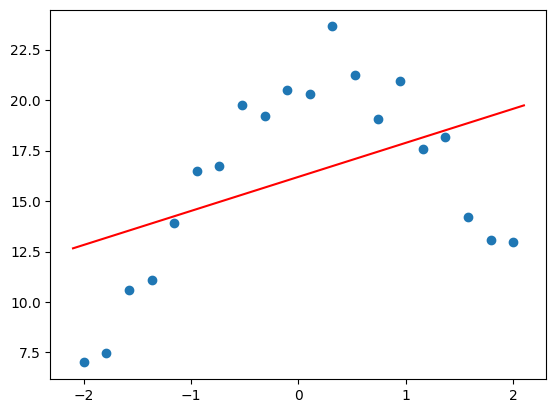

In [29]:
plot_poly(1)
#underfitted model

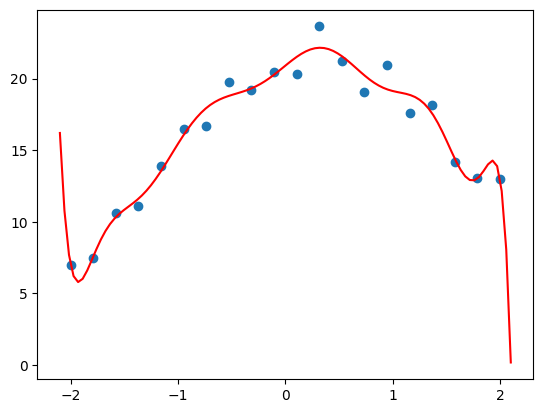

In [30]:
plot_poly(12)
#overfitted model

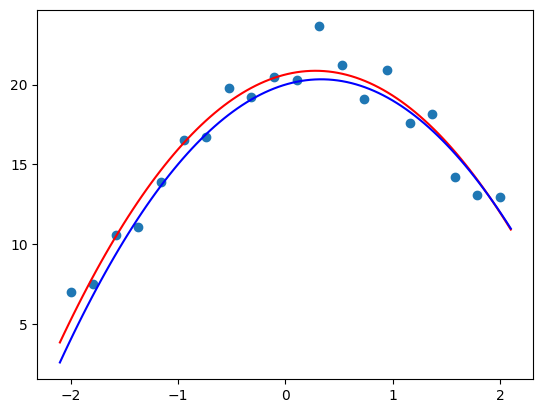

In [31]:
plot_poly(2)
plot_function(f, color = 'b')

How to recognize if the model is underfitting or overfitting
> We use validation set to understand if the model is overfitting or underfitting
* Underfit: metrics over validation shows poor performance from the beginning 
* Overfit: metrics over validations shows performance improvement over few epochs and later starts to show performance degradation



Transformes uses `DatasetDict` for holding your training and validation sets. To split the data in some ration we use `train_test_split`


In [32]:
dds = tok_ds.train_test_split(0.25, seed = 42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

DatasetDict uses `test` as validation set

## Test set
Test set is another dataset which is held out from training as well as reporting metrics
- Accuracy of model on the test set is only ever checked after completing entire training process, including trying different models, training methods, data processing, etc.\
This helps in coincidental case when model gets overfitted on the validation set

In [33]:
# The separate test set which we set earlier
eval_df.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [34]:
eval_df['input'] = 'CASE1: ' + eval_df.context + '| CASE2: ' + eval_df.target + '| ANC1: ' + eval_df.anchor 
eval_df.head()

,id,anchor,target,context,input
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,CASE1: G02| CASE2: inorganic photoconductor dr...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,CASE1: F23| CASE2: altering gas flow| ANC1: ad...
2,36baf228038e314b,lower trunnion,lower locating,B60,CASE1: B60| CASE2: lower locating| ANC1: lower...
3,1f37ead645e7f0c8,cap component,upper portion,D06,CASE1: D06| CASE2: upper portion| ANC1: cap co...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,CASE1: H04| CASE2: artificial neural network| ...


In [35]:
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

## Metric and correlation
We will use sklearn lib to use `california housing` dataset to understand how pearson coefficient affects

In [36]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)

housing

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
7506,3.0550,37.0,5.152778,1.048611,729.0,5.062500,33.92,-118.28,1.054
4720,3.0862,35.0,4.697897,1.055449,1159.0,2.216061,34.05,-118.37,3.453
12888,2.5556,24.0,4.864905,1.129222,1631.0,2.395007,38.66,-121.35,1.057
13344,3.0057,32.0,4.212687,0.936567,1378.0,5.141791,34.05,-117.64,0.969
7173,1.9083,42.0,3.888554,1.039157,1535.0,4.623494,34.05,-118.19,1.192
...,...,...,...,...,...,...,...,...,...
10535,5.5677,4.0,5.921914,1.120907,834.0,2.100756,33.50,-117.70,2.454
3029,2.9952,44.0,5.534296,1.055355,2140.0,2.575211,35.13,-119.47,0.638
7985,2.5068,26.0,4.240693,1.067394,4066.0,2.609756,33.86,-118.16,1.563
13724,1.4480,37.0,4.327434,1.026549,1316.0,3.882006,34.06,-117.19,0.728


We can see all the correlation coefficients for every combination of columns in this dataset by calling np.corrcoef:

In [37]:
np.set_printoptions(precision = 2, suppress = True)
np.corrcoef(housing, rowvar = False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [38]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [39]:
# Creating function to just return a single number for corrcoef
def corr(x,y): return np.corrcoef(x,y)[0][1]
corr(housing.MedInc, housing.MedHouseVal)

0.6760250732906

In [40]:
# Visualising corrcoef
def show_corr(df, a, b):
    x, y = df[a], df[b]
    plt.scatter(x,y, alpha = 0.5,s=4)
    plt.title(f'{a} vs {b}; r:{corr(x,y):.2f}')
    plt.xlabel('{a}')
    plt.ylabel('{b}')

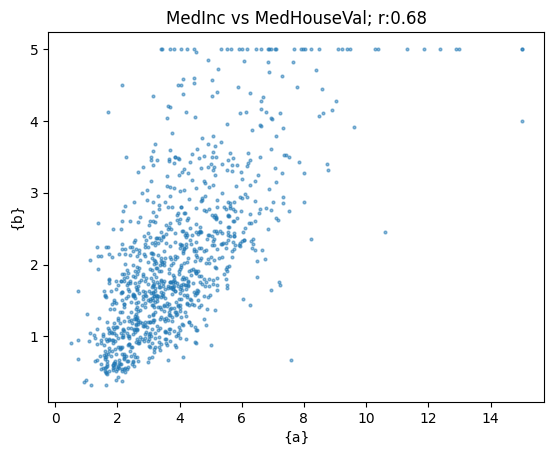

In [41]:
show_corr(housing, 'MedInc', 'MedHouseVal')

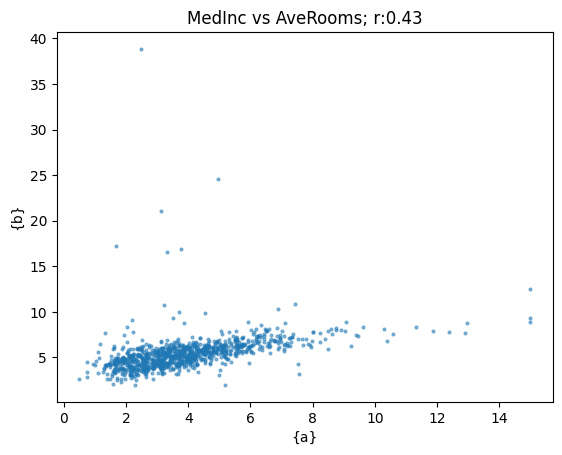

In [42]:
show_corr(housing, 'MedInc', 'AveRooms')

Outlier

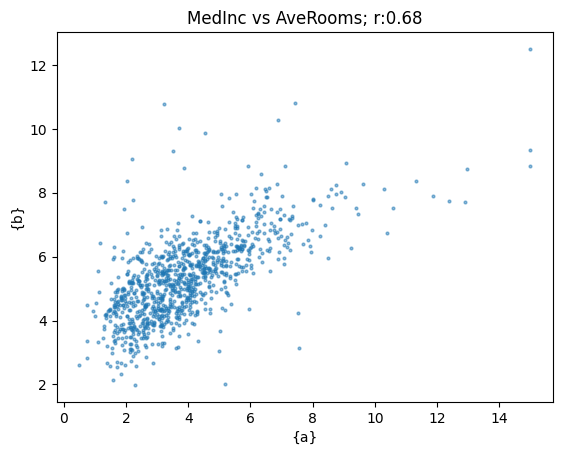

In [43]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

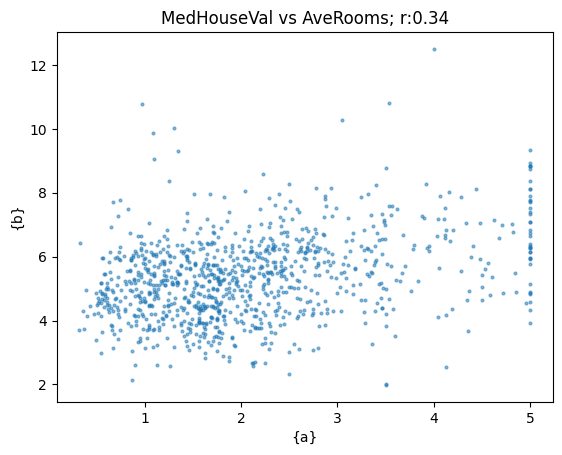

In [44]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

r is 0.34 which is becoming quite weak

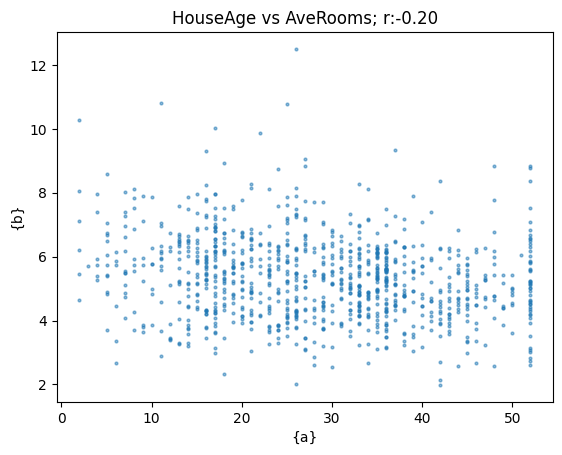

In [45]:
show_corr(subset, 'HouseAge', 'AveRooms')

a correlation of -0.2 shows a very weak negative trend

Transformers expectts the metrics to be returnes as a `dict`. Since that way the trainer knows what label to use

In [46]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

## Training

In [47]:
from transformers import TrainingArguments, Trainer

2024-02-13 16:17:47.692421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 16:17:47.692535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 16:17:47.834159: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [48]:
bs = 128
epochs = 4
lr = 8e-5

In [49]:
# Transformers uses TrainingArguments class to set up arguments. 
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [50]:
# We create model and trainer which is class that combines the model and data togeter like `learner`
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.024842,0.799079
2,No log,0.022814,0.821278
3,0.029100,0.022341,0.831492
4,0.029100,0.022619,0.832497


TrainOutput(global_step=856, training_loss=0.022458910942077637, metrics={'train_runtime': 274.1571, 'train_samples_per_second': 399.1, 'train_steps_per_second': 3.122, 'total_flos': 717218678299260.0, 'train_loss': 0.022458910942077637, 'epoch': 4.0})

In [52]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

array([[ 0.5 ],
       [ 0.71],
       [ 0.57],
       [ 0.31],
       [-0.07],
       [ 0.54],
       [ 0.51],
       [-0.05],
       [ 0.31],
       [ 1.09],
       [ 0.25],
       [ 0.23],
       [ 0.73],
       [ 0.89],
       [ 0.75],
       [ 0.37],
       [ 0.25],
       [-0.03],
       [ 0.67],
       [ 0.35],
       [ 0.57],
       [ 0.2 ],
       [ 0.07],
       [ 0.2 ],
       [ 0.58],
       [-0.03],
       [-0.04],
       [-0.04],
       [-0.03],
       [ 0.66],
       [ 0.31],
       [ 0.01],
       [ 0.7 ],
       [ 0.55],
       [ 0.36],
       [ 0.2 ]])

In [53]:
preds = np.clip(preds, 0, 1)
preds

array([[0.5 ],
       [0.71],
       [0.57],
       [0.31],
       [0.  ],
       [0.54],
       [0.51],
       [0.  ],
       [0.31],
       [1.  ],
       [0.25],
       [0.23],
       [0.73],
       [0.89],
       [0.75],
       [0.37],
       [0.25],
       [0.  ],
       [0.67],
       [0.35],
       [0.57],
       [0.2 ],
       [0.07],
       [0.2 ],
       [0.58],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.66],
       [0.31],
       [0.01],
       [0.7 ],
       [0.55],
       [0.36],
       [0.2 ]])

In [54]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

852